In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



--- Step Rate Regression: Test Set ---
MAE: 4.26
CWA (±10%): 98.66%
CER (>25%): 0.18%

--- Activity Classification: Test Set ---
Accuracy: 0.993
F1 (weighted): 0.993

Per-class report:

              precision    recall  f1-score   support

     Jogging      0.994     0.988     0.991       910
     Walking      0.991     0.996     0.994      1257

    accuracy                          0.993      2167
   macro avg      0.993     0.992     0.992      2167
weighted avg      0.993     0.993     0.993      2167


Confusion Matrix (counts):


,Pred:Jogging,Pred:Walking
True:Jogging,899,11
True:Walking,5,1252


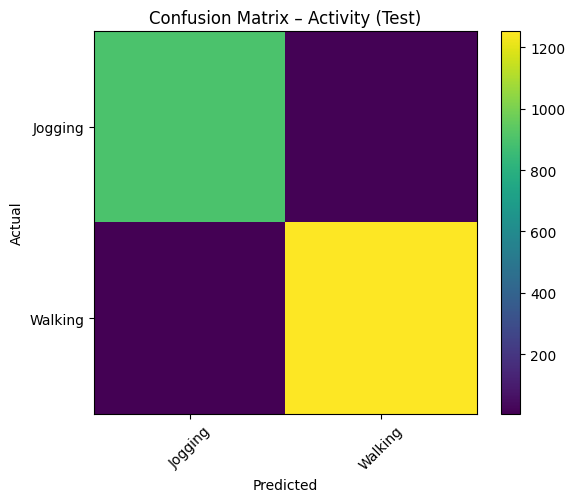

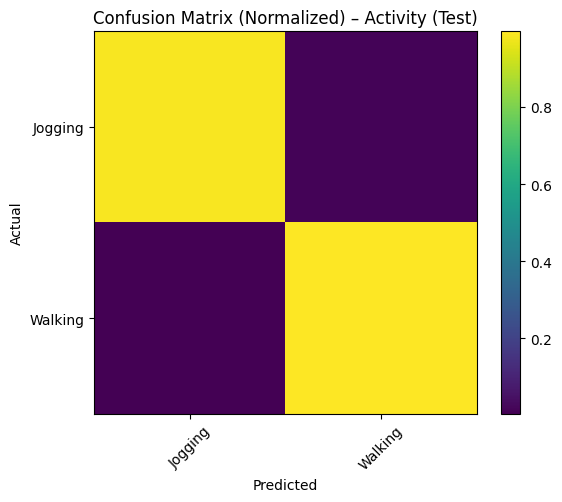

Saved confusion matrix images to artifacts/eval/


In [5]:
# === Walk & Beat – Evaluation-only snippet ===
# Loads saved test split + models and computes metrics incl. confusion matrix.

import os, json, joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error, accuracy_score, f1_score,
    confusion_matrix, classification_report
)

# ---------- 1) Load manifest, data, and models ----------
MANIFEST_PATH = "/content/drive/MyDrive/Walk and Beat/artifacts/splits/manifest.json"  # adjust if needed
with open(MANIFEST_PATH) as f:
    manifest = json.load(f)

# X_test (drop helper column if present)
X_test = pd.read_parquet(manifest["paths"]["X_test_parquet"])
if "row_id" in X_test.columns:
    X_test = X_test.drop(columns=["row_id"])

# y_test targets
y_reg_test  = pd.read_csv(manifest["paths"]["y_reg_test_csv"])["step_rate"]
y_class_test = pd.read_csv(manifest["paths"]["y_class_test_csv"])["label"]

# Models
reg = joblib.load(manifest["paths"]["best_regressor_pkl"])
clf = joblib.load(manifest["paths"]["best_classifier_pkl"])

# ---------- 2) Predictions ----------
y_reg_pred = reg.predict(X_test)
y_cls_pred = clf.predict(X_test)

# ---------- 3) Bespoke metrics ----------
def cadence_window_accuracy(y_true, y_pred, pct=0.10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return float((np.abs(y_pred - y_true) <= pct * np.abs(y_true)).mean())

def critical_error_rate(y_true, y_pred, pct=0.25):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return float((np.abs(y_pred - y_true) > pct * np.abs(y_true)).mean())

# ---------- 4) Print metrics ----------
print("\n--- Step Rate Regression: Test Set ---")
print(f"MAE: {mean_absolute_error(y_reg_test, y_reg_pred):.2f}")
print(f"CWA (±10%): {cadence_window_accuracy(y_reg_test, y_reg_pred):.2%}")
print(f"CER (>25%): {critical_error_rate(y_reg_test, y_reg_pred):.2%}")

print("\n--- Activity Classification: Test Set ---")
acc = accuracy_score(y_class_test, y_cls_pred)
f1w = f1_score(y_class_test, y_cls_pred, average='weighted')
print(f"Accuracy: {acc:.3f}")
print(f"F1 (weighted): {f1w:.3f}")
print("\nPer-class report:\n")
print(classification_report(y_class_test, y_cls_pred, digits=3))

# ---------- 5) Confusion matrix (print + plot) ----------
labels = list(clf.classes_)  # preserves training label order
cm = confusion_matrix(y_class_test, y_cls_pred, labels=labels)

# As a table
cm_df = pd.DataFrame(cm, index=[f"True:{l}" for l in labels],
                        columns=[f"Pred:{l}" for l in labels])
print("\nConfusion Matrix (counts):")
display(cm_df)

# Plot
os.makedirs("artifacts/eval", exist_ok=True)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix – Activity (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.tight_layout()
plt.savefig("artifacts/eval/confusion_matrix.png", dpi=150)
plt.show()

# Optional normalized CM
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6,5))
plt.imshow(cm_norm, interpolation='nearest')
plt.title('Confusion Matrix (Normalized) – Activity (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.tight_layout()
plt.savefig("artifacts/eval/confusion_matrix_normalized.png", dpi=150)
plt.show()

print("Saved confusion matrix images to artifacts/eval/")



In [8]:
# === EVALUATION-ONLY PIPELINE (NO TRAINING) ===
# - Loads saved models + eval splits from artifacts/
# - Builds song_df from Spotify CSVs
# - Runs Iteration 1 (direct) + Iteration 2 (HMM) recommendations
# - Computes bespoke metrics and saves results
# - Evaluates classifier (confusion matrix)

import os, numpy as np, pandas as pd, joblib
from pathlib import Path


# Colab/Drive fallback (edit if your Drive path differs)
ARTIFACTS = Path("/content/drive/MyDrive/Walk and Beat/artifacts")

EVALDIR = ARTIFACTS / "eval"
EVALDIR.mkdir(parents=True, exist_ok=True)

# Spotify CSV locations (Colab Drive example; change to your paths)
features_path = "/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify_features_data_2023.csv"
tracks_path   = "/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify_tracks_data_2023.csv"  # optional
artist_path   = "/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify_artist_data_2023.csv"
albums_path   = "/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify-albums_data_2023.csv"
data_path     = "/content/drive/MyDrive/Walk and Beat/data/Spotify Dataset/spotify_data_12_20_2023.csv"   # optional

# -------------------------------
# 1) Load artifacts (models + data)
# -------------------------------
reg = joblib.load(ARTIFACTS / "best_regressor.pkl")
clf_path = ARTIFACTS / "best_classifier.pkl"
clf = joblib.load(clf_path) if clf_path.exists() else None

# Preferred: full PCA dataset for per-user recs
pca_full_fp = ARTIFACTS / "features_pca.parquet"
has_full = pca_full_fp.exists()

if has_full:
    features_pca_df = pd.read_parquet(pca_full_fp)
else:
    # Minimal: evaluation split only (no per-user breakdown if user column missing)
    X_test = pd.read_parquet(EVALDIR / "X_test.parquet")
    y_reg_test = pd.read_csv(EVALDIR / "y_reg_test.csv")["step_rate"].values
    y_class_test = pd.read_csv(EVALDIR / "y_class_test.csv")["label"].values
    features_pca_df = X_test.copy()
    features_pca_df["user"] = 0  # dummy user if full DF not available

# -------------------------------
# 2) Build song_df (BPM + names + duration)
# -------------------------------
features_df_songs = pd.read_csv(features_path)
albums_df = pd.read_csv(albums_path)
artist_df = pd.read_csv(artist_path)

# Standardize bpm column name
if "tempo" in features_df_songs.columns:
    features_df_songs = features_df_songs.rename(columns={"tempo": "bpm"})

merge_cols = ["track_id", "track_name", "artist_id"]
if "duration_ms" in albums_df.columns:
    merge_cols.append("duration_ms")

song_df = pd.merge(
    features_df_songs,
    albums_df[merge_cols],
    left_on="id", right_on="track_id", how="inner"
)
song_df = pd.merge(
    song_df,
    artist_df[["id", "name"]].rename(columns={"id":"artist_id", "name":"artist_name"}),
    on="artist_id", how="left"
)

keep_cols = ["track_name", "artist_name", "bpm"]
if "duration_ms" in song_df.columns:
    keep_cols.append("duration_ms")
song_df = song_df[keep_cols].dropna(subset=["track_name", "artist_name", "bpm"]).reset_index(drop=True)
song_df["bpm"] = pd.to_numeric(song_df["bpm"], errors="coerce")
song_df = song_df.dropna(subset=["bpm"])

print("song_df preview:\n", song_df.head())

# -------------------------------
# 3) Helpers (shared)
# -------------------------------
def recommend_dynamic_song(pred_bpm, song_df, tolerance=10):
    cand = song_df[(song_df["bpm"] >= pred_bpm - tolerance) & (song_df["bpm"] <= pred_bpm + tolerance)]
    if not cand.empty:
        idx = (cand["bpm"] - pred_bpm).abs().idxmin()
        return cand.loc[idx]
    idx = (song_df["bpm"] - pred_bpm).abs().idxmin()
    return song_df.loc[idx]

def get_track_duration(track_name, song_df):
    if "duration_ms" in song_df.columns:
        d = song_df[song_df["track_name"] == track_name]["duration_ms"]
        if not d.empty:
            return float(d.median())/1000.0
    return 180.0  # default seconds

def cadence_music_fit_score(step_rates, song_bpms, tolerance=10):
    sr = np.asarray(step_rates, dtype=float)
    bpm = np.asarray(song_bpms, dtype=float)
    return float(np.mean(np.abs(sr - bpm) <= tolerance))

def song_segment_stats(song_sequence, window_len=5):
    s = pd.Series(song_sequence)
    change = s.ne(s.shift())   # first occurrence of a new song
    idx = np.where(change)[0]
    if len(idx) < 2:
        return {"num_changes": 0, "mean_duration": float(len(s)*window_len)}
    lengths = np.diff(np.append(idx, len(s)))
    return {"num_changes": int(len(idx)-1), "mean_duration": float(np.mean(lengths)*window_len)}

# -------------------------------
# 4) Iteration 1: direct BPM match
# -------------------------------
pc_cols = [c for c in features_pca_df.columns if c.startswith("PC")]
assert len(pc_cols) > 0, "No PCA columns (PC*) found."

features_pca_df = features_pca_df.copy()
features_pca_df["pred_step_rate"] = reg.predict(features_pca_df[pc_cols])

iter1_rows = []
for user in features_pca_df["user"].unique():
    dfu = features_pca_df[features_pca_df["user"] == user].copy()
    rec_tracks, rec_artists, rec_bpms = [], [], []
    for sr in dfu["pred_step_rate"].values:
        song = recommend_dynamic_song(sr, song_df, tolerance=10)
        rec_tracks.append(song["track_name"])
        rec_artists.append(song["artist_name"])
        rec_bpms.append(float(song["bpm"]))
    dfu["iter1_rec_song"] = rec_tracks
    dfu["iter1_rec_artist"] = rec_artists
    dfu["iter1_rec_bpm"] = rec_bpms
    iter1_rows.append(dfu)

iter1_df = pd.concat(iter1_rows, ignore_index=True)

# Per-user bespoke metrics (iteration 1)
iter1_user_metrics = []
for user in iter1_df["user"].unique():
    du = iter1_df[iter1_df["user"] == user]
    fit = cadence_music_fit_score(du["pred_step_rate"], du["iter1_rec_bpm"], tolerance=10)
    seg = song_segment_stats(du["iter1_rec_song"])
    iter1_user_metrics.append({
        "user": user,
        "cadence_music_fit": fit,
        "num_song_changes": seg["num_changes"],
        "mean_song_segment_sec": seg["mean_duration"]
    })
iter1_metrics_df = pd.DataFrame(iter1_user_metrics)
print("\n--- Iteration 1 (direct) system-wide averages ---")
print(f"Average cadence-music fit: {iter1_metrics_df['cadence_music_fit'].mean():.3f}")
print(f"Average number of song changes per session: {iter1_metrics_df['num_song_changes'].mean():.1f}")
print(f"Average song segment duration (sec): {iter1_metrics_df['mean_song_segment_sec'].mean():.2f}")

# Save Iteration 1 outputs
iter1_df.to_parquet(EVALDIR / "iter1_recommendations.parquet", index=False)
iter1_metrics_df.to_csv(EVALDIR / "iter1_user_metrics.csv", index=False)

# -------------------------------
# 5) Iteration 2: HMM smoothing + durations
# -------------------------------
def cadence_state(step_rate):
    if step_rate < 110: return "slow_walk"
    if step_rate < 140: return "fast_walk"
    return "jog"

features_pca_df["cadence_state"] = features_pca_df["pred_step_rate"].apply(cadence_state)

# Learn transition matrix over users
states = sorted(features_pca_df["cadence_state"].unique())
state2idx = {s:i for i,s in enumerate(states)}
T = np.zeros((len(states), len(states)), dtype=float)
for u in features_pca_df["user"].unique():
    seq = features_pca_df.loc[features_pca_df["user"] == u, "cadence_state"].values
    for i in range(len(seq)-1):
        T[state2idx[seq[i]], state2idx[seq[i+1]]] += 1.0
row_sums = T.sum(axis=1, keepdims=True)
T = np.where(row_sums==0, 1, T)
T = T / T.sum(axis=1, keepdims=True)
pd.DataFrame(T, index=states, columns=states).to_csv(EVALDIR / "iter2_hmm_transition_matrix.csv")

def viterbi_smooth(pred_states, T, state2idx, states, mismatch_penalty=2.0, eps=1e-8):
    n = len(pred_states); S = T.shape[0]
    dp = np.full((n, S), -np.inf); ptr = np.zeros((n, S), dtype=int)
    for s in range(S):
        dp[0, s] = 0.0 if states[s] == pred_states[0] else -np.inf
    logT = np.log(T + eps)
    for t in range(1, n):
        for s in range(S):
            emit = 0.0 if states[s] == pred_states[t] else -mismatch_penalty
            v = dp[t-1] + logT[:, s] + emit
            ptr[t, s] = int(np.argmax(v))
            dp[t, s] = v[ptr[t, s]]
    path, s = [], int(np.argmax(dp[-1]))
    for t in range(n-1, -1, -1):
        path.append(states[s]); s = ptr[t, s]
    return path[::-1]

# Run HMM + duration-aware recommendation
hmm_rows = []
for user in features_pca_df["user"].unique():
    dfu = features_pca_df[features_pca_df["user"] == user].copy()
    smooth_states = viterbi_smooth(dfu["cadence_state"].tolist(), T, state2idx, states)
    dfu["hmm_state"] = smooth_states

    rec_tracks, rec_artists, rec_bpms = [], [], []
    cur_song = cur_artist = None
    cur_bpm, song_timer = None, 0
    last_state = None

    for _, r in dfu.iterrows():
        state = r["hmm_state"]; pred_bpm = r["pred_step_rate"]
        if (state != last_state) or (song_timer <= 0):
            s = recommend_dynamic_song(pred_bpm, song_df, tolerance=10)
            cur_song, cur_artist, cur_bpm = s["track_name"], s["artist_name"], float(s["bpm"])
            dur = get_track_duration(cur_song, song_df)
            song_timer = int(max(1, dur // 5))
            last_state = state
        rec_tracks.append(cur_song); rec_artists.append(cur_artist); rec_bpms.append(cur_bpm)
        song_timer -= 1

    dfu["hmm_rec_song"] = rec_tracks
    dfu["hmm_rec_artist"] = rec_artists
    dfu["hmm_rec_bpm"] = rec_bpms
    hmm_rows.append(dfu)

iter2_df = pd.concat(hmm_rows, ignore_index=True)

# Per-user bespoke metrics (iteration 2)
iter2_user_metrics = []
for user in iter2_df["user"].unique():
    du = iter2_df[iter2_df["user"] == user]
    fit = cadence_music_fit_score(du["pred_step_rate"], du["hmm_rec_bpm"], tolerance=10)
    seg = song_segment_stats(du["hmm_rec_song"])
    iter2_user_metrics.append({
        "user": user,
        "cadence_music_fit": fit,
        "num_song_changes": seg["num_changes"],
        "mean_song_segment_sec": seg["mean_duration"]
    })
iter2_metrics_df = pd.DataFrame(iter2_user_metrics)
print("\n--- Iteration 2 (HMM) system-wide averages ---")
print(f"Average cadence-music fit: {iter2_metrics_df['cadence_music_fit'].mean():.3f}")
print(f"Average number of song changes per session: {iter2_metrics_df['num_song_changes'].mean():.1f}")
print(f"Average song segment duration (sec): {iter2_metrics_df['mean_song_segment_sec'].mean():.2f}")

# Save Iteration 2 outputs
iter2_df.to_parquet(EVALDIR / "iter2_hmm_recommendations.parquet", index=False)
iter2_metrics_df.to_csv(EVALDIR / "iter2_hmm_user_metrics.csv", index=False)

print("\nSaved files:")
for p in [
    EVALDIR / "iter1_recommendations.parquet",
    EVALDIR / "iter1_user_metrics.csv",
    EVALDIR / "iter2_hmm_transition_matrix.csv",
    EVALDIR / "iter2_hmm_recommendations.parquet",
    EVALDIR / "iter2_hmm_user_metrics.csv",
]:
    print(" -", p.resolve())

# -------------------------------
# 6) Optional: Classifier eval (confusion matrix) on saved test split
# -------------------------------
try:
    import seaborn as sns, matplotlib.pyplot as plt
    X_test = pd.read_parquet(EVALDIR / "X_test.parquet")
    y_class_test = pd.read_csv(EVALDIR / "y_class_test.csv")["label"].values
    if clf is not None:
        y_class_pred = clf.predict(X_test)
        from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
        cm = confusion_matrix(y_class_test, y_class_pred, labels=np.unique(y_class_test))
        print("\n--- Activity Classification: Test Set ---")
        print("Accuracy:", accuracy_score(y_class_test, y_class_pred))
        print("F1 (weighted):", f1_score(y_class_test, y_class_pred, average="weighted"))
        print("\nPer-class report:\n", classification_report(y_class_test, y_class_pred, digits=3))
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=np.unique(y_class_test),
                    yticklabels=np.unique(y_class_test))
        plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()
    else:
        print("\n(best_classifier.pkl not found – skipping confusion matrix.)")
except Exception as e:
    print("Classifier eval skipped:", e)


song_df preview:
                                           track_name             artist_name  \
0                   When The Day Is Coming To An End                 Adele H   
1                    Treat You Better - Instrumental  Molotov Cocktail Piano   
2                               Youth - Instrumental          Piano Dreamers   
3  Here We Go Again (Slow) [In The Style Of Demi ...              Sing2Piano   
4                                         Skyscraper         Music Box Mania   

       bpm  
0   75.639  
1  166.048  
2  100.256  
3   69.976  
4  159.953  

--- Iteration 1 (direct) system-wide averages ---
Average cadence-music fit: 1.000
Average number of song changes per session: 199.6
Average song segment duration (sec): 5.00

--- Iteration 2 (HMM) system-wide averages ---
Average cadence-music fit: 0.517
Average number of song changes per session: 6.3
Average song segment duration (sec): 143.63

Saved files:
 - /content/drive/MyDrive/Walk and Beat/artifacts/eval/iter1